# Projeto Final - Pré-treino SQuAD 2.0 - Tarefa de VQA

Nesse notebook tento fazer o pré-treino para uma tarefa de perguntas e respostas a partir de um dataset de imagens sintéticas geradas a partir do Squad v2. Em um primeiro momento, treinei para a tarefa de OCR, onde a pergunta é única sobre qual a sequência total da imagem, e no segundo momento (este notebook) treino para a tarefa de pergunta e resposta com as perguntas e respostas do dataset original.

### Sobre as imagens

Algumas características do dataset sintético gerado:
- Tamanho de imagem: 576x768
- Tamanho da sequência: até 256 palavras
- Tamanho da fonte: de 10 a 16
- Ruído na imagem: sim, de -30 a 30.
- Âncora de texto variável: sim, pode estar de 10 a `0.4*img_height` pixels do topo da imagem


### Sobre as tarefas de pré-treino

Penso em fazer duas tarefas de pré-treino com o dataset Squad v2 antes de treinar no DocVQA:
- Tarefa de OCR. Os textos se repetem n vezes no dataset e a função de gerar a imagem pode fazê-los variar em altura da âncora e tamanho da letra.
- Tarefa de VQA. Pergunta e resposta do squad v2. No dataset, existem perguntas sem respostas, por exemplo.


Nesse notebook está a execução da segund tarefa de pré-treino, de OCR.
Tinha iniciado o pré-treino (1 época) com um dataset com ruído gaussiano de -30 a 30 nas imagens e tamanho de letra de 18 a 20 (pois tinha treinado mais fácil inicialmente). Retirei o ruído e reduzi as letras para continuar.


### Sobre o treino

- Uso do t5-base (d_model = 768).
- Geração de patches 24x24 da imagem de entrada. Depois, reshape para `batch x 384 x 768`.
- Concatenação da pergunta junto aos embeddings de texto. As perguntas tem shape: `batch x 20 x 768`.
- Sequence length: 256
- Otimizador: Adafactor
- Batch size: 2
- Grad accum: 8
- Limit val batches: 0.2
- Tamanho dos conjuntos:
    - Treino: 1.000.000
    - Validação: 1.000
    - Teste: 1.000

## Importações e downloads

In [1]:
!nvidia-smi

Mon Jan  4 13:19:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install ftfy datasets pytorch-lightning transformers==3.5.1 --quiet

In [3]:
!pip install neptune-client neptune-contrib[all] neptune-notebooks --quiet

In [1]:
neptune_params = {
    'api_key': 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZDYyNzIxNTYtMjFkMi00ODk3LTk3ZjQtOWRjYzQ4NjAxNjIzIn0=',
    'project_name': 'lupozz/ia376-squad-vqa'
}

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# import os
import glob
import json
import random
import numpy as np
from PIL import Image
from imageio import imread
from collections import OrderedDict
from tqdm.notebook import tqdm
from itertools import product
from functools import partial
from copy import copy
from datetime import datetime
from pathlib import Path

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from fairseq.optim.adafactor import Adafactor

from pytorch_lightning.loggers.neptune import NeptuneLogger

from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration

import pytorch_lightning as pl
import transformers

print(f"""PyTorch Version: {torch.__version__}
          \rLightning Version: {pl.__version__}
          \rTransformers Version: {transformers.__version__}""")

model_name = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(model_name)

PyTorch Version: 1.4.0
Lightning Version: 1.0.6
Transformers Version: 3.5.1


In [4]:
if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu" 
print(dev)
device = torch.device(dev)

cuda:0


In [5]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf .

Skipping existing item: file://./arial.ttf


In [6]:
from datasets import load_dataset

dataset = load_dataset('squad_v2')

Reusing dataset squad_v2 (/root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/0e44b51f4035c15e218d53dc9eea5fe7123341982e524818b8500e4094fffb7b)


In [7]:
print(dataset['train'][0]['answers'])

{'answer_start': [269], 'text': ['in the late 1990s']}


In [8]:
print(dataset['validation'])

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})


## Funções auxiliares

### Métricas

In [9]:
# Métricas feitas pelo professor de um notebook de outra aula

import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

### Geração da imagem sintética com texto mascarado

In [10]:
# Modifiquei a partir do notebook da gabriela
import textwrap
import unicodedata
import ftfy

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from imageio import imsave

def text_to_image(text: str, max_width: int, max_height: int):
    """Geração de uma imagem sintética com texto mascarado.
    
    Modifiquei em cima da função do notebook da Gabriela.
    
    """

    font_size = np.random.randint(10, 16)
    font = ImageFont.truetype("arial.ttf", font_size)
    
    image = Image.new('RGB', (max_width, max_height), (255, 255, 255))  # white background.
    d = ImageDraw.Draw(image)

    # Correção do texto, do notebook do Diedre
    text = ftfy.fix_text(text.encode('ascii', errors='ignore').decode())
    text = ' '.join(text.split()[:256])

    # Wrap da sequência
    wraps = textwrap.wrap(text, width=int(max_width*0.95 // font_size*2))
        
    # Pontos âncoras do texto aleatórios
    left_border = np.random.randint(10, 16)
    top_border = np.random.randint(10, max_height*0.4)
    
    for col, wrap in enumerate(wraps): 
        d.text((left_border, top_border + 1.2 * font_size * col), 
               wrap, font=font, fill=(0, 0, 0))
            
    arr = np.array(image).astype(np.int)
    
    # Possível adição de ruído na imagem.
    #if np.random.choice([0, 1]):
    arr += np.random.uniform(-15, 15, size=arr.shape).astype(np.int)
    
    return {
        'image':arr.clip(0, 255).astype(np.uint8),
        'text': text,           # texto original
    }

In [11]:
output = text_to_image(dataset['train'][0]['context'], 
                       max_width=384, 
                       max_height=512)

In [12]:
image = output['image']

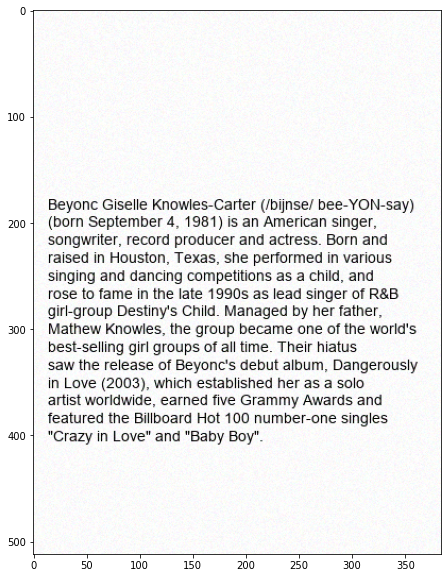

In [13]:
plt.figure(figsize=(15, 10))
plt.imshow(image)

## Dataset

In [14]:
class Squadv2ImageDataset(Dataset):
    def __init__(self, dataset, start, end, max_width, max_height, tokenizer, transform=None):
        self.dataset = dataset
        self.start = start
        self.end = end
        self.max_width = max_width
        self.max_height = max_height
        self.transform = transform
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        if self.start:
            data = self.dataset[int(self.start + index)]
        else:
            data = self.dataset[int(index)]
            
        text = data['context']
        
        output = text_to_image(text, 
                               max_width=self.max_width, 
                               max_height=self.max_height)
        image = output['image']

        answers = data['answers']['text']
        if answers:
            i = np.random.randint(0, len(answers))
            answer = answers[i]
        else:
            answer = 'No answer.'
        
        if self.transform:
            image = self.transform(image)

        return image, text, data['question'], answer

    def __len__(self):
        return (self.end - self.start)
    
    def show_batch(self, size=1, figsize=(5, 10), display_patches=False):
        samples = np.random.randint(0, high=self.__len__(), size=size)
        for i, sample in enumerate(samples):
            image, text, question, answer = self.__getitem__(sample)

            print(f'{question} {answer}')
            print(f'Full text: {text}')

            plt.figure(figsize=figsize)
            plt.imshow((image.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])
            plt.show()

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])

# Dataset de treino vai até a amostra 1.000.000
# Validação e teste tem 1k amostras obtidas a partir desse valor
train_size = int(129000)

train_ds = Squadv2ImageDataset(dataset=dataset['train'],
                                start=0,
                                end=train_size,
                                max_width=576,
                                max_height=768,
                                tokenizer=tokenizer,
                                transform=transform)

val_ds = Squadv2ImageDataset(dataset=dataset['train'],
                              start=train_size,
                              end=train_size + 1300,
                              max_width=576,
                              max_height=768,
                              tokenizer=tokenizer,
                              transform=transform)

test_ds = Squadv2ImageDataset(dataset=dataset['validation'],
                               start=0,
                               end=5000,
                               max_width=576,
                               max_height=768,
                               tokenizer=tokenizer,
                               transform=transform)

In [16]:
image, text, question, answer = val_ds[123]

In [17]:
image.shape

torch.Size([3, 768, 576])

In [18]:
text

'Technologies based upon the polymerase chain reaction (PCR) method will become nearly ubiquitous gold standards of diagnostics of the near future, for several reasons. First, the catalog of infectious agents has grown to the point that virtually all of the significant infectious agents of the human population have been identified. Second, an infectious agent must grow within the human body to cause disease; essentially it must amplify its own nucleic acids in order to cause a disease. This amplification of nucleic acid in infected tissue offers an opportunity to detect the infectious agent by using PCR. Third, the essential tools for directing PCR, primers, are derived from the genomes of infectious agents, and with time those genomes will be known, if they are not already.'

In [19]:
len(text.split())

125

Who has hunting been forbidden to since early Christian times? Roman Catholic Church clerics
Full text: From early Christian times, hunting has been forbidden to Roman Catholic Church clerics. Thus the Corpus Juris Canonici (C. ii, X, De cleric. venat.) says, "We forbid to all servants of God hunting and expeditions through the woods with hounds; and we also forbid them to keep hawks or falcons." The Fourth Council of the Lateran, held under Pope Innocent III, decreed (canon xv): "We interdict hunting or hawking to all clerics." The decree of the Council of Trent is worded more mildly: "Let clerics abstain from illicit hunting and hawking" (Sess. XXIV, De reform., c. xii), which seems to imply that not all hunting is illicit, and canonists generally make a distinction declaring noisy (clamorosa) hunting unlawful, but not quiet (quieta) hunting.


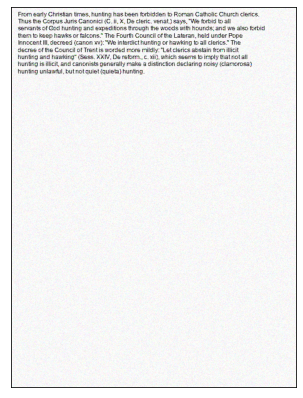

What methods are highly sensitive, specifc and rapid tests used to identify microorganisms? Serological
Full text: Serological methods are highly sensitive, specific and often extremely rapid tests used to identify microorganisms. These tests are based upon the ability of an antibody to bind specifically to an antigen. The antigen, usually a protein or carbohydrate made by an infectious agent, is bound by the antibody. This binding then sets off a chain of events that can be visibly obvious in various ways, dependent upon the test. For example, "Strep throat" is often diagnosed within minutes, and is based on the appearance of antigens made by the causative agent, S. pyogenes, that is retrieved from a patients throat with a cotton swab. Serological tests, if available, are usually the preferred route of identification, however the tests are costly to develop and the reagents used in the test often require refrigeration. Some serological methods are extremely costly, although when commo

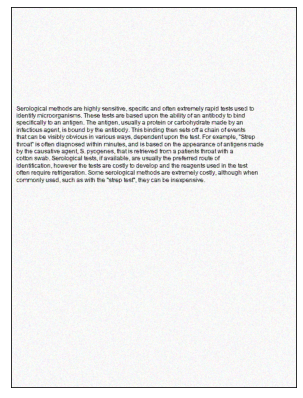

What type of financial impact does hunting have on the U.S.? significant financial impact
Full text: Hunting also has a significant financial impact in the United States, with many companies specialising in hunting equipment or speciality tourism. Many different technologies have been created to assist hunters, even including iPhone applications. Today's hunters come from a broad range of economic, social, and cultural backgrounds. In 2001, over thirteen million hunters averaged eighteen days hunting, and spent over $20.5 billion on their sport.[citation needed] In the US, proceeds from hunting licenses contribute to state game management programs, including preservation of wildlife habitat.


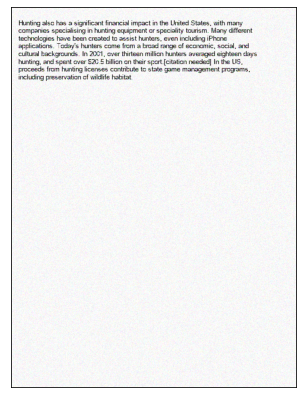

Aristotle said parts have existence outside of what? No answer.
Full text: For example, a horse eats grass: the horse changes the grass into itself; the grass as such does not persist in the horse, but some aspect of it—its matter—does. The matter is not specifically described (e.g., as atoms), but consists of whatever persists in the change of substance from grass to horse. Matter in this understanding does not exist independently (i.e., as a substance), but exists interdependently (i.e., as a "principle") with form and only insofar as it underlies change. It can be helpful to conceive of the relationship of matter and form as very similar to that between parts and whole. For Aristotle, matter as such can only receive actuality from form; it has no activity or actuality in itself, similar to the way that parts as such only have their existence in a whole (otherwise they would be independent wholes).


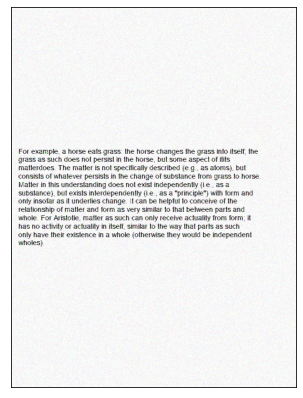

How many electrons are there in the generations? No answer.
Full text: The Standard Model groups matter particles into three generations, where each generation consists of two quarks and two leptons. The first generation is the up and down quarks, the electron and the electron neutrino; the second includes the charm and strange quarks, the muon and the muon neutrino; the third generation consists of the top and bottom quarks and the tau and tau neutrino. The most natural explanation for this would be that quarks and leptons of higher generations are excited states of the first generations. If this turns out to be the case, it would imply that quarks and leptons are composite particles, rather than elementary particles.


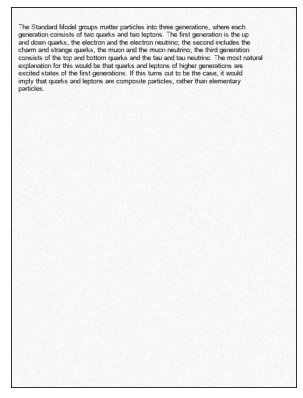

How many stars is Kathmandu's Grand Hotel? four
Full text: With the opening of the tourist industry after the change in the political scenario of Nepal in 1950, the hotel industry drastically improved. Now Kathmandu boasts several luxury such as the Hyatt Regency, Dwarika's, theYak & Yeti, The Everest Hotel, Hotel Radisson, Hotel De L'Annapurna, The Malla Hotel, Shangri-La Hotel (which is not operated by the Shangri-La Hotel Group) and The Shanker Hotel. There are several four-star hotels such as Hotel Vaishali, Hotel Narayani, The Blue Star and Grand Hotel. The Garden Hotel, Hotel Ambassador, and Aloha Inn are among the three-star hotels in Kathmandu. Hotels like Hyatt Regency, De L'Annapurna and Hotel Yak & Yeti are among the five-star hotels providing casinos as well.


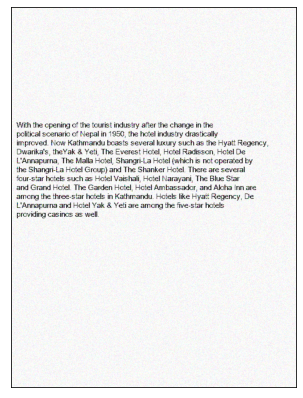

What does gravity contribute to in a system? No answer.
Full text: In the context of relativity, mass is not an additive quantity, in the sense that one can add the rest masses of particles in a system to get the total rest mass of the system. Thus, in relativity usually a more general view is that it is not the sum of rest masses, but the energy–momentum tensor that quantifies the amount of matter. This tensor gives the rest mass for the entire system. "Matter" therefore is sometimes considered as anything that contributes to the energy–momentum of a system, that is, anything that is not purely gravity. This view is commonly held in fields that deal with general relativity such as cosmology. In this view, light and other massless particles and fields are part of matter.


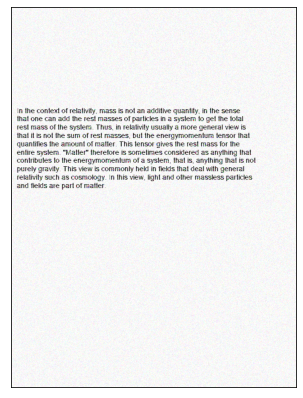

What needs to be combined with infected tissue to provide a biochemical diagnosis of an infectious disease? No answer.
Full text: The isolation of enzymes from infected tissue can also provide the basis of a biochemical diagnosis of an infectious disease. For example, humans can make neither RNA replicases nor reverse transcriptase, and the presence of these enzymes are characteristic of specific types of viral infections. The ability of the viral protein hemagglutinin to bind red blood cells together into a detectable matrix may also be characterized as a biochemical test for viral infection, although strictly speaking hemagglutinin is not an enzyme and has no metabolic function.


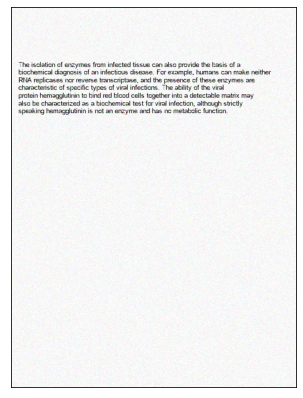

Trade between what two countries typically went through ancient Kathmandu? India and Tibet
Full text: Eventually, the Licchavi ruler Gunakamadeva merged Koligram and Dakshin Koligram, founding the city of Kathmandu. The city was designed in the shape of Chandrahrasa, the sword of Manjushri. The city was surrounded by eight barracks guarded by Ajimas. One of these barracks is still in use at Bhadrakali (in front of Singha Durbar). The city served as an important transit point in the trade between India and Tibet, leading to tremendous growth in architecture. Descriptions of buildings such as Managriha, Kailaskut Bhawan, and Bhadradiwas Bhawan have been found in the surviving journals of travelers and monks who lived during this era. For example, the famous 7th-century Chinese traveller Xuanzang described Kailaskut Bhawan, the palace of the Licchavi king Amshuverma. The trade route also led to cultural exchange as well. The artistry of the Newar people—the indigenous inhabitants of the K

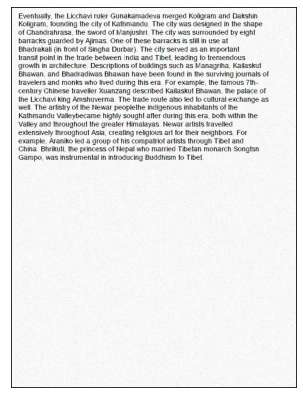

Electrical impulses trigger what? No answer.
Full text: Injured heart tissue conducts electrical impulses more slowly than normal heart tissue. The difference in conduction velocity between injured and uninjured tissue can trigger re-entry or a feedback loop that is believed to be the cause of many lethal arrhythmias. The most serious of these arrhythmias is ventricular fibrillation (V-Fib/VF), an extremely fast and chaotic heart rhythm that is the leading cause of sudden cardiac death. Another life-threatening arrhythmia is ventricular tachycardia (V-tach/VT), which can cause sudden cardiac death. However, VT usually results in rapid heart rates that prevent the heart from pumping blood effectively. Cardiac output and blood pressure may fall to dangerous levels, which can lead to further coronary ischemia and extension of the infarct.


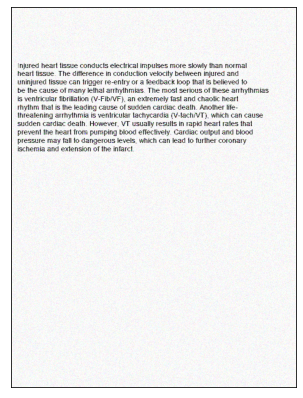

In [20]:
val_ds.show_batch(size=10, figsize=(10, 7))

## Classes do Modelo

### Modelo

In [31]:
class T5Finetuner(pl.LightningModule):

    def __init__(self, train_dataloader, val_dataloader, test_dataloader, 
                 tokenizer, params, manual_checkpoint=False, save_name='model',
                 date=None):
        super(T5Finetuner, self).__init__()

        self.params = params
        self.only_decoder = self.params['only_decoder']
        self.learning_rate = params['learning_rate']
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        self.tokenizer = tokenizer
        self.t5 = T5ForConditionalGeneration.from_pretrained(params['model_name'])

        # Para conversão dos patches 24x24 em embeddings (384, 768)
        self.patch = nn.Conv2d(in_channels=3, out_channels=384, kernel_size=28, stride=24, padding=4)
        
        # Para conversão dos patches em embeddings (256, 768)
        """
        self.conv_bridge = torch.nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)),
            ('relu1', torch.nn.ReLU()),
            ('batch_norm1', torch.nn.BatchNorm2d(32)),
            ('conv2', nn.Conv2d(32, 64, kernel_size=5, stride=3, padding=2)),
            ('relu2', torch.nn.ReLU()),
            ('batch_norm2', torch.nn.BatchNorm2d(64)),
            ('conv3', nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)),
            ('relu3', torch.nn.ReLU()),
            ('batch_norm3', torch.nn.BatchNorm2d(128)),
            ('conv4', nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)),
            ('relu4', torch.nn.ReLU()),
            ('batch_norm4', torch.nn.BatchNorm2d(256))
        ]))
        """
        
        # self.image_positional = nn.Embedding(384, self.t5.config.d_model)
        self.question_positional = nn.Embedding(20, self.t5.config.d_model)
        # self.type_embedding = nn.Embedding(2, self.t5.config.d_model)

        self.manual_checkpoint = manual_checkpoint
        self.save_name = save_name
        self.run_datetime = date if date else datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    def _generate_tokens(self, embedding):
        ''' Peguei do código do Diedre

        Adaptação de código da aula 10 do semestre passado. Usa features para gerar frases com T5.

        A forma que faz mais sentido pra mim é usar encoder_outputs como sendo as features e deixar o t5 usar
        embeddings de texto padrão na decodificação. Não sei se está 100% correto.

        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((embedding.shape[0], 1),
                                 self.t5.config.decoder_start_token_id,
                                 dtype=torch.long).to(embedding.device)

        if not self.only_decoder:
            # Passa os embeddings pelo encoder
            encoder_hidden_states = self.t5.get_encoder()(inputs_embeds=embedding)

        for step in range(max_length-1):
            if not self.only_decoder:
                # Full T5, usa os embeddings computados pelo encoder na decodificação
                logits = self.t5(decoder_input_ids=decoded_ids,
                                 encoder_outputs=encoder_hidden_states)[0]
            else:
                logits = self.t5(decoder_input_ids=decoded_ids,
                                 encoder_outputs=(embedding,))[0]
                
            next_token_logits = logits[:, -1, :]

            # Greedy decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids


    def _embeds_forward(self, img):
        features = img
        
        # Transform patches to input them in the T5 model
        features = self.patch(features)
        
        # Reshape the output to the 2D format of the tranformer.
        # Shape: (batch, 512, 768)
        inputs = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.t5.config.d_model)
        
        # inputs += self.type_embedding(torch.tensor(0, device=inputs.device))
        # inputs += self.image_positional(torch.arange(inputs.shape[1], 
        #                                              device=inputs.device))
                
        return inputs
    
    
    def _embeds_question(self, question):
        # Perguntas tokenizadas são convertidas para embeddings
        question_embedding = self.t5.shared(question)
        
        # question_embedding += self.type_embedding(torch.tensor(1, device=question.device))
        question_embedding += self.question_positional(torch.arange(question_embedding.shape[1],
                                                                    device=question.device))
        
        return question_embedding
    

    def forward(self, batch):
        images, questions, answers, encoded_questions, encoded_answers = batch

        # Shape: (batch x 384 x 768)
        image_embeddings = self._embeds_forward(images)

        # Shape: (batch x 20 x 768)
        question_embeddings = self._embeds_question(encoded_questions)
        
        # Concatenação com os embeddings da imagem
        # Shape: (batch x 404 x 768)
        embeddings = torch.cat((image_embeddings, question_embeddings), dim=1)

        if self.training:
            if self.only_decoder:
                outputs = self.t5(encoder_outputs=(embeddings,), 
                                  labels=encoded_answers,
                                  return_dict=True)
            else:
                outputs = self.t5(inputs_embeds=embeddings, 
                                  labels=encoded_answers,
                                  return_dict=True)
            
            return outputs.loss
        else:
            return self._generate_tokens(image_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        answers = batch[2]
        return {"pred": decoded_pred, "target": answers}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        answers = batch[2]
        return {"pred": decoded_pred, "target": answers}

    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)
        
        if self.manual_checkpoint and self.global_step != 0:
            step, epoch, save_name = self.global_step, self.current_epoch, self.save_name
            ckpt_path = Path(f"checkpoints/{save_name}/{self.run_datetime}")
            ckpt_name = f'{save_name}-epoch-{epoch}-step-{str(step).zfill(6)}-val_f1-{f1:.5f}-EM-{exact:.5f}.pt'
            
            ckpt_path.mkdir(parents=True, exist_ok=True)
            torch.save(self.state_dict(), ckpt_path / ckpt_name)

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)

    def configure_optimizers(self):
        if self.params['optimizer'] == 'Adafactor':
            optimizer = Adafactor(
                    [p for p in self.parameters() if p.requires_grad],
                    scale_parameter=False, relative_step=False, 
                    lr=self.learning_rate)
        elif self.params['optimizer'] == 'Adam':
            optimizer = torch.optim.Adam(
                [p for p in self.parameters() if p.requires_grad],
                lr=self.learning_rate, eps=1e-08)
        return optimizer

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

### Collate

In [32]:
def collate_fn(batch, params={'seq_len_questions': 20,
                              'seq_len': 128,
                              'task': 'squad'}):
    """ Tokenização do batch e alguns pré-processamentos.
    
    """
    imgs = torch.as_tensor(torch.stack([sample[0] for sample in batch]))
    text = [sample[1] for sample in batch]

    if params['task'] == 'vqa':
        # Pergunta e resposta do dataset squad v2.
        questions = [sample[2] for sample in batch]
        answers = [sample[3] for sample in batch]
    elif params['task'] == 'ocr':
        # Na tarefa de ocr, a pergunta é sempre a mesma e a resposta é o texto da imagem.
        questions = ['What is the whole sentence?' for i in range(len(batch))]
        answers = [' '.join(t.split()[:params['input_seq_len']]) for t in text]
    
    # Dict com 'input_ids' e 'attention_mask'
    # seq_len_questions != seq_len do texto
    encoded_questions = tokenizer.batch_encode_plus(questions, 
                                          # padding='longest',
                                          padding='max_length',
                                          truncation=True,
                                          max_length=params['seq_len_questions'],
                                          return_tensors='pt')['input_ids']
    
    encoded_answers = tokenizer.batch_encode_plus(answers, 
                                                  # padding='longest',
                                                  padding='max_length',
                                                  truncation=True,
                                                  max_length=params['input_seq_len'],
                                                  return_tensors='pt')['input_ids']
    
    return imgs, questions, answers, encoded_questions, encoded_answers

## Parâmetros e Dataloaders

In [39]:
params = {
    'model_name': model_name, # definido lá no topo do código
    'only_decoder': False,
    'task': 'vqa',
    'optimizer': 'Adafactor',
    'batch_size': 2,
    'batch_size_eval': 2,
    'num_workers': 4,
    'input_seq_len': 256,     # seq len de entrada
    'seq_len': 256,           # seq len do texto gerado
    'seq_len_questions': 20,  # seq len das perguntas
    'learning_rate': 1e-5,
    'max_epochs': 30,
    'patience': 10,
    'monitor_variable': 'val_f1', # Critério do early stopping,
}

_collate = partial(collate_fn, params=params)

train_loader = DataLoader(train_ds,
                          batch_size=params['batch_size'],
                          num_workers=params['num_workers'], 
                          collate_fn=_collate)

val_loader = DataLoader(val_ds,
                        batch_size=params['batch_size_eval'],
                        num_workers=params['num_workers'],
                        collate_fn=_collate)

test_loader = DataLoader(test_ds,
                         batch_size=params['batch_size_eval'],
                         num_workers=params['num_workers'],
                         collate_fn=_collate)

## Teste preliminar

Para debug.

In [34]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    tokenizer=tokenizer,
                    params=params)

trainer = pl.Trainer(gpus=1, 
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     fast_dev_run=True)

trainer.fit(model)
trainer.test(model)
del model, trainer  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
2021-01-04 13:24:56 | INFO | lightning | GPU available: True, used: True
TPU available: False, using: 0 TPU cores
2021-01-04 13:24:56 | INFO | lightning | TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-04 13:24:56 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
2021-01-04 13:24:56 | INFO | lightning | Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | t5                  | T5ForConditionalGeneration | 222 M 
1 | patch               | Conv2d                     | 903 K 
2 | question_positional | Embedding                  | 15 K  
2021-01-04 13:24:56 | INFO | lightning | 
  | Name                | Type                       | Params
-


Sample Target: No answer.
Prediction: 





Sample Target: 10th and 11th centuries
Prediction: 

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_exact': 0.0, 'test_f1': 0.0}
--------------------------------------------------------------------------------



## Treino rápido para ver se a loss está reduzindo

In [36]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=None,
                    tokenizer=tokenizer,
                    params=params)

trainer = pl.Trainer(gpus=1, 
                     max_epochs=30,
                     check_val_every_n_epoch=10,
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     overfit_batches=2)
trainer.fit(model)
del model, trainer  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
2021-01-04 13:26:55 | INFO | lightning | GPU available: True, used: True
TPU available: False, using: 0 TPU cores
2021-01-04 13:26:55 | INFO | lightning | TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-04 13:26:55 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | t5                  | T5ForConditionalGeneration | 222 M 
1 | patch               | Conv2d                     | 903 K 
2 | question_positional | Embedding                  | 15 K  
2021-01-04 13:26:55 | INFO | lightning | 
  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | t5                  | T5ForConditionalGeneration | 222 M 
1 | patch               | Conv2d                     | 903 K 
2 | question_positional | Embeddin


Sample Target: Houston, Texas
Prediction: 




Sample Target: singing and dancing
Prediction: 




Sample Target: Houston, Texas
Prediction: 




Sample Target: 2003
Prediction: 




# Treino

In [40]:
# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    prefix="squad-v2-vqa",
    filepath="logs/{epoch}-{val_f1:.2f}-{val_exact:.2f}", 
    monitor="val_f1", 
    mode="max",
)

callbacks = [pl.callbacks.EarlyStopping(monitor=params['monitor_variable'], 
                                        patience=params["patience"], 
                                        mode='max')]

run_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

neptune_logger = NeptuneLogger(
    api_key=neptune_params['api_key'],
    project_name=neptune_params['project_name'],
    params=params,
    tags=['TRAIN', f"task: {params['task']}", 
          'with-weights',
          'patch', 'with-noise',
          '768x576', 'question-positional', 
          'no-type-embedding',
          'not-only-decoder', 'normed-img',
          run_time],
)

trainer = pl.Trainer(gpus=1,
                     precision=32,
                     log_gpu_memory=True,
                     max_epochs=params['max_epochs'],
                     # check_val_every_n_epoch=1,
                     progress_bar_refresh_rate=16,
                     accumulate_grad_batches=8,
                     limit_val_batches=0.2,
                     val_check_interval=10000,
                     profiler=True,
                     logger=neptune_logger,
                     # callbacks=callbacks,
                     checkpoint_callback=checkpoint_callback)

model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    tokenizer=tokenizer,
                    params=params,
                    manual_checkpoint=True,    # Salva checkpoints a cada validação
                    save_name='squad-v2-vqa',  # Nome do modelo salvo
                    date=run_time)

weights = 'checkpoints/squad-v2-ocr/2020-12-30_11-55-47/squad-v2-ocr-epoch-8-step-069503-val_f1-0.20024-EM-0.00000.pt'
#weights = ''
if weights:
    print('Loading pretrained weights...')
    model.load_state_dict(torch.load(weights))

trainer.fit(model)

https://ui.neptune.ai/lupozz/ia376-squad-vqa/e/IAS-13


NeptuneLogger will work in online mode
2021-01-04 20:57:03 | INFO | lightning | NeptuneLogger will work in online mode
GPU available: True, used: True
2021-01-04 20:57:03 | INFO | lightning | GPU available: True, used: True
TPU available: False, using: 0 TPU cores
2021-01-04 20:57:03 | INFO | lightning | TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-04 20:57:03 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading pretrained weights...



  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | t5                  | T5ForConditionalGeneration | 222 M 
1 | patch               | Conv2d                     | 903 K 
2 | question_positional | Embedding                  | 15 K  
2021-01-04 20:57:11 | INFO | lightning | 
  | Name                | Type                       | Params
-------------------------------------------------------------------
0 | t5                  | T5ForConditionalGeneration | 222 M 
1 | patch               | Conv2d                     | 903 K 
2 | question_positional | Embedding                  | 15 K  



Sample Target: No answer.
Prediction: Sichuan consists of three geographically very distinct parts. The eastern part is mostly within the fertile Sichuan basin and is surrounded by the Himalayas to the west, followed by the Himachal Pradesh to the south, and then by the Yangtze to the southwest. The Sichuan Basin, a significant geographical feature of China, is located in southwest China, and is surrounded by the Himachal mountains. A significant portion of this area is known as Kuomintang or Muomintang or Muomintang, both of which are located in the Sichuan Basin and are known to China as well.



2021-01-04 21:00:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 21:10:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 21:23:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 21:36:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 21:49:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 22:01:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 22:14:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 22:17:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: animals
Prediction: 



2021-01-04 22:47:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 23:03:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 23:16:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 23:29:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 23:42:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-04 23:52:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 00:04:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 00:08:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 00:38:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 00:51:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:03:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:16:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:29:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:42:20 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:52:00 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 01:58:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 02:28:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 02:41:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 02:50:55 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 03:03:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 03:13:20 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 03:26:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 03:35:50 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 03:48:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: primary care physicians or internal medicine specialists
Prediction: 



2021-01-05 04:18:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 04:34:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 04:47:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 05:00:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 05:13:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 05:25:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 05:38:46 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 05:38:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 06:08:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 06:21:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 06:37:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 06:47:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:00:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:12:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:28:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:29:01 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 07:29:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:42:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 07:52:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 08:04:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 08:17:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 08:27:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 08:40:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 08:52:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 09:05:46 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 09:18:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: red blood cells
Prediction: 



2021-01-05 09:28:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 09:41:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 09:54:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 10:03:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 10:16:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 10:29:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 10:38:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 10:48:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 10:58:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 11:11:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 11:24:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 11:36:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 11:46:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 11:59:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: greatly outweighed by the cost
Prediction: 



2021-01-05 12:09:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 12:18:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 12:31:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 12:44:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 12:54:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 13:06:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 13:16:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 13:29:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 13:42:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 13:52:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 14:04:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 14:17:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 14:30:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 14:43:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 14:50:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:03:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:09:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:22:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:34:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:47:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 15:57:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 16:10:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 16:20:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 16:32:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 16:45:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 16:58:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 17:11:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 17:24:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 17:36:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 17:46:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 17:59:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: S. pyogenes
Prediction: 



2021-01-05 18:05:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 18:18:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 18:28:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 18:41:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 18:53:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 19:06:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 19:16:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: Hunting
Prediction: a a slug



2021-01-05 19:42:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 19:55:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 20:07:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 20:20:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 20:33:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 20:46:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 20:56:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: s



2021-01-05 21:02:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 21:12:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 21:25:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 21:34:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 21:47:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 22:00:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 22:13:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: following a disease
Prediction: 



2021-01-05 22:23:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 22:36:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 22:45:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 22:58:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 23:11:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 23:21:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 23:34:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: 



2021-01-05 23:44:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-05 23:57:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 00:09:50 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 00:22:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 00:32:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 00:45:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 00:54:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: a



2021-01-06 01:24:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 01:33:50 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 01:46:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 01:56:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 02:09:00 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 02:21:55 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 02:31:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 02:44:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 02:57:20 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 03:10:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: a sp



2021-01-06 03:32:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 03:48:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 03:58:20 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 04:11:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 04:23:55 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 04:33:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 04:46:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: No answer.
Prediction: a styro



2021-01-06 05:08:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 05:18:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 05:31:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 05:44:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 05:53:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 06:06:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 06:19:31 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: by medical history and physical examination
Prediction: a a slug



2021-01-06 06:42:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 06:55:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 07:08:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 07:18:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 07:30:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 07:43:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 07:53:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: resources could be targeted to the communities at greatest risk
Prediction: a sp s



2021-01-06 08:06:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 08:16:31 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 08:29:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 08:39:01 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 08:51:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 09:04:46 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 09:17:31 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: Frequent hand washing
Prediction: a



2021-01-06 09:28:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 09:40:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 09:53:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 10:06:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 10:19:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 10:29:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 10:38:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina


Sample Target: prevention
Prediction: a a sluglugs.



2021-01-06 11:07:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina

2021-01-06 11:20:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment IAS-13. Cause: Error(code=400, message='X-coordina



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_fit_start        	|  4.9188e-05     	|  4.9188e-05     
on_validation_start 	|  0.023745       	|  0.59363        
on_validation_epoch_start	|  2.4752e-05     	|  0.00061881     
on_validation_batch_start	|  3.139e-05      	|  0.097999       
validation_step_end 	|  2.956e-05      	|  0.092287       
on_validation_batch_end	|  0.00022961     	|  0.71686        
on_validation_epoch_end	|  9.231e-05      	|  0.0023077      
on_validation_end   	|  0.43348        	|  10.837         
on_train_start      	|  0.026371       	|  0.026371       
on_epoch_start      	|  0.0029233      	|  0.011693       
on_train_epoch_start	|  2.2461e-05     	|  8.9845e-05     
get_train_batch     	|  0.0028766      	|  736.01         
on_batch_start      	|  3.7546e-05     	|  9.6066         
on_train_batch_start	|  1.8531e-05     	|  4.7414         
training_ste

1

In [30]:
# Guardando aqui no fim do código, pode ser útil
import gc
# del model, trainer

gc.collect()
torch.cuda.memory_allocated() / 1024

882514.0

# Conclusões
